# Comparative proteomics analysis with iTRAQ labels 

Using PEAKS Q table output 

In [1]:
import pandas as pd
import numpy as np
import re
from bioinfokit import analys, visuz
from scipy import stats as st
from statsmodels.stats.multitest import multipletests as multi

## Load table

In [2]:
peaks = pd.read_csv(r'./PSEP1KO_QUANTITATION_4/proteins.csv', sep=',')

In [3]:
peaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 27 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Protein Group                                     3659 non-null   int64  
 1   Protein ID                                        3659 non-null   int64  
 2   Accession                                         3659 non-null   object 
 3   Significance                                      3659 non-null   float64
 4   -10lgP                                            3659 non-null   float64
 5   Intensity iTRAQ8-113                              3659 non-null   float64
 6   Intensity iTRAQ8-114                              3659 non-null   float64
 7   Intensity iTRAQ8-115                              3659 non-null   float64
 8   Intensity iTRAQ8-116                              3659 non-null   float64
 9   Intensity iTRAQ8-11

In [4]:
peaks.head()

,Protein Group,Protein ID,Accession,Significance,-10lgP,Intensity iTRAQ8-113,Intensity iTRAQ8-114,Intensity iTRAQ8-115,Intensity iTRAQ8-116,Intensity iTRAQ8-117,...,Intensity WT(iTRAQ8-113; iTRAQ8-114; iTRAQ8-115),Intensity OE(iTRAQ8-116; iTRAQ8-117; iTRAQ8-118),Ratio WT(iTRAQ8-113; iTRAQ8-114; iTRAQ8-115),Ratio OE(iTRAQ8-116; iTRAQ8-117; iTRAQ8-118),Coverage (%),#Peptides,#Unique,PTM,Avg. Mass,Description
0,5,1,PhpapaCp032,0.73,498.86,91230000.0,92410000.0,82530000.0,78890000.0,93300000.0,...,88720000.0,87670000.0,1.00,0.99,81,32,29,Carbamidomethylation; iTRAQ 8plex (K N-term);...,53264,NP_904195.1 atpB ATP synthase CF1 beta subunit
1,3,3,Pp3c18_21210V3.1.p,11.82,495.74,30250000.0,30200000.0,31400000.0,27010000.0,27980000.0,...,30620000.0,26390000.0,1.00,0.86,29,49,17,iTRAQ 8plex (K N-term); Oxidation (M),84520,PREDICTED: 5-methyltetrahydropteroyltriglutama...
2,2,14,Pp3c15_12990V3.1.p,22.79,483.32,76990000.0,75410000.0,80670000.0,91180000.0,93660000.0,...,77690000.0,90860000.0,1.00,1.17,75,61,61,Carbamidomethylation; iTRAQ 8plex (K N-term);...,103477,PREDICTED: lipoxygenase 3 chloroplastic [Bras...
3,2,15,Pp3c15_13020V3.1.p,22.79,483.32,76990000.0,75410000.0,80670000.0,91180000.0,93660000.0,...,77690000.0,90860000.0,1.00,1.17,75,61,61,Carbamidomethylation; iTRAQ 8plex (K N-term);...,103477,PREDICTED: linoleate 13S-lipoxygenase 3-1 chl...
4,6,35,Pp3c15_12980V3.1.p,0.12,481.39,11150000.0,12870000.0,13730000.0,12250000.0,12790000.0,...,12580000.0,12510000.0,1.00,0.99,20,57,14,iTRAQ 8plex (K N-term),105280,unknown [Picea sitchensis].


## Table for analysis

Reduce redundancy by removing the proteins in protein groups

In [5]:
peaks_drop = peaks.drop_duplicates('Protein Group')

Select columns

In [34]:
peaks_drop_filt = peaks_drop[['Accession', 'Significance', '-10lgP',
       'Intensity iTRAQ8-113', 'Intensity iTRAQ8-114', 'Intensity iTRAQ8-115',
       'Intensity iTRAQ8-116', 'Intensity iTRAQ8-117', 'Intensity iTRAQ8-118',
       'Intensity WT(iTRAQ8-113; iTRAQ8-114; iTRAQ8-115)',
       'Intensity OE(iTRAQ8-116; iTRAQ8-117; iTRAQ8-118)','Description']]

In [35]:
peaks_drop_filt.head()

,Accession,Significance,-10lgP,Intensity iTRAQ8-113,Intensity iTRAQ8-114,Intensity iTRAQ8-115,Intensity iTRAQ8-116,Intensity iTRAQ8-117,Intensity iTRAQ8-118,Intensity WT(iTRAQ8-113; iTRAQ8-114; iTRAQ8-115),Intensity OE(iTRAQ8-116; iTRAQ8-117; iTRAQ8-118),Description
0,PhpapaCp032,0.73,498.86,91230000.0,92410000.0,82530000.0,78890000.0,93300000.0,90830000.0,88720000.0,87670000.0,NP_904195.1 atpB ATP synthase CF1 beta subunit
1,Pp3c18_21210V3.1.p,11.82,495.74,30250000.0,30200000.0,31400000.0,27010000.0,27980000.0,24190000.0,30620000.0,26390000.0,PREDICTED: 5-methyltetrahydropteroyltriglutama...
2,Pp3c15_12990V3.1.p,22.79,483.32,76990000.0,75410000.0,80670000.0,91180000.0,93660000.0,87470000.0,77690000.0,90860000.0,PREDICTED: lipoxygenase 3 chloroplastic [Bras...
4,Pp3c15_12980V3.1.p,0.12,481.39,11150000.0,12870000.0,13730000.0,12250000.0,12790000.0,12490000.0,12580000.0,12510000.0,unknown [Picea sitchensis].
5,Pp3c21_3730V3.1.p,1.54,475.71,9513000.0,8529000.0,9511000.0,9799000.0,9289000.0,7604000.0,9184000.0,8897000.0,na


Transform significance

In [36]:
peaks_drop_filt['p-value'] = peaks_drop_filt['Significance'].map(lambda x: 10**(x/-10))

/var/folders/44/h_wp5fcx00gfvg6f4ysgbzyr0000gn/T/ipykernel_32191/4292680796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_drop_filt['p-value'] = peaks_drop_filt['Significance'].map(lambda x: 10**(x/-10))


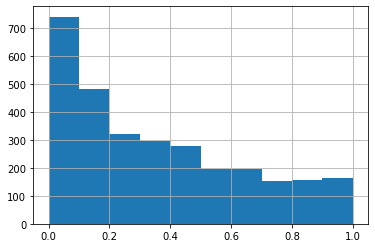

In [37]:
peaks_drop_filt['p-value'].hist();

Multiple testing correction

In [38]:
peaks_drop_filt['p_adj'] = multi(peaks_drop_filt['p-value'], alpha=0.05, method='fdr_bh')[1]

/var/folders/44/h_wp5fcx00gfvg6f4ysgbzyr0000gn/T/ipykernel_32191/4071541274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_drop_filt['p_adj'] = multi(peaks_drop_filt['p-value'], alpha=0.05, method='fdr_bh')[1]


In [39]:
peaks_drop_filt.head()

,Accession,Significance,-10lgP,Intensity iTRAQ8-113,Intensity iTRAQ8-114,Intensity iTRAQ8-115,Intensity iTRAQ8-116,Intensity iTRAQ8-117,Intensity iTRAQ8-118,Intensity WT(iTRAQ8-113; iTRAQ8-114; iTRAQ8-115),Intensity OE(iTRAQ8-116; iTRAQ8-117; iTRAQ8-118),Description,p-value,p_adj
0,PhpapaCp032,0.73,498.86,91230000.0,92410000.0,82530000.0,78890000.0,93300000.0,90830000.0,88720000.0,87670000.0,NP_904195.1 atpB ATP synthase CF1 beta subunit,0.845279,0.922572
1,Pp3c18_21210V3.1.p,11.82,495.74,30250000.0,30200000.0,31400000.0,27010000.0,27980000.0,24190000.0,30620000.0,26390000.0,PREDICTED: 5-methyltetrahydropteroyltriglutama...,0.065766,0.371829
2,Pp3c15_12990V3.1.p,22.79,483.32,76990000.0,75410000.0,80670000.0,91180000.0,93660000.0,87470000.0,77690000.0,90860000.0,PREDICTED: lipoxygenase 3 chloroplastic [Bras...,0.005260,0.260290
4,Pp3c15_12980V3.1.p,0.12,481.39,11150000.0,12870000.0,13730000.0,12250000.0,12790000.0,12490000.0,12580000.0,12510000.0,unknown [Picea sitchensis].,0.972747,0.985629
5,Pp3c21_3730V3.1.p,1.54,475.71,9513000.0,8529000.0,9511000.0,9799000.0,9289000.0,7604000.0,9184000.0,8897000.0,na,0.701455,0.833257


## Volcano plot

Add Fold Change values

In [40]:
peaks_drop_filt = peaks_drop_filt.rename(columns={'Intensity WT(iTRAQ8-113; iTRAQ8-114; iTRAQ8-115)':'Intensity_WT', 'Intensity OE(iTRAQ8-116; iTRAQ8-117; iTRAQ8-118)':"Intensity_OE"})

In [45]:
def FC(row):
    if row[r'Intensity_OE'] == 0:
        return 0.01/row[r'Intensity_WT']
    elif row[r'Intensity_WT'] == 0:
        return row[r'Intensity_OE']/0.01
    return row[r'Intensity_OE']/row[r'Intensity_WT']

In [46]:
peaks_drop_filt['FC_KO/WT'] = peaks_drop_filt.apply(FC, axis=1)

In [47]:
peaks_drop_filt['FC_KO/WT, log2'] = peaks_drop_filt['FC_KO/WT'].apply(np.log2)

Search for significant proteins

In [50]:
peaks_drop_filt[peaks_drop_filt['p_adj']<0.05].sort_values(by='FC_KO/WT', ascending=True).head(20)

,Accession,Significance,-10lgP,Intensity iTRAQ8-113,Intensity iTRAQ8-114,Intensity iTRAQ8-115,Intensity iTRAQ8-116,Intensity iTRAQ8-117,Intensity iTRAQ8-118,Intensity_WT,Intensity_OE,Description,p-value,p_adj,FC_KO/WT,"FC_KO/WT, log2"
758,Pp3c23_11670V3.1.p,48.52,244.15,5013000.0,5059000.0,5101000.0,4108000.0,4158000.0,4141000.0,5058000.0,4136000.0,Similar to Phosphomannomutase; acc. no. Q9UTJ2...,0.000014,0.020978,0.817715,-0.290331
1249,Pp3c14_4160V3.1.p,48.54,194.36,731100.0,734100.0,736400.0,648700.0,646700.0,653300.0,733800.0,649600.0,PREDICTED: 60S ribosomal protein L6-3-like [Ta...,0.000014,0.020978,0.885255,-0.175835


Volcano plot

In [48]:
# Protein names for volcano plot
names = {"Pp3c24_4490V3.1.p":"oxalate-CoA ligase",
         "Pp3c7_19850V3.1.p":"PR",
         "Pp3c1_18940V3.1.p":"PAL",
         "Pp3c9_1620V3.1.p":"PPO",
         "Pp3c1_1940V3.1.p":"JAL3",
         "Pp3c23_11670V3.1.p":"PMM",
         "Pp3c17_22100V3.1.p":"PYL5",
         "Pp3c2_7850V3.1.p":"SNAP25",
         "Pp3c19_4870V3.1.p":"DRP1",
         "Pp3c7_10220V3.1.p":"CLTA",
         "Pp3c3_14480V3.1.p":"SSU",
         "Pp3c11_15790V3.1.p":"GAPDH",
         "Pp3c1_23410V3.1.p":"DUF1955",
         "PhpapaCp031":"RbcL"}

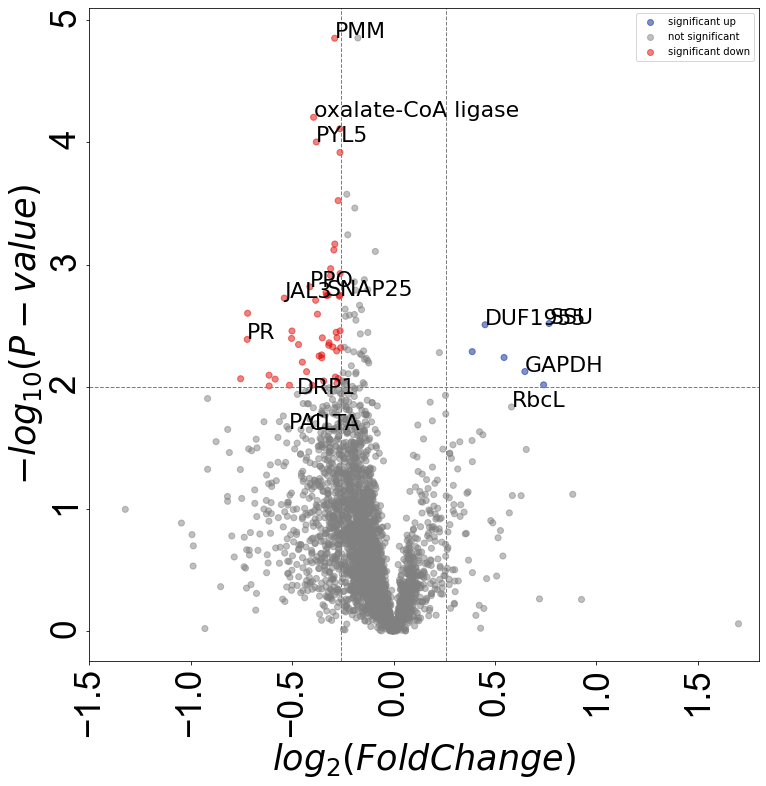

In [49]:
visuz.gene_exp.volcano(df=peaks_drop_filt,
                       lfc='FC_KO/WT, log2',
                       legendanchor=(1,1),
                       pv='p-value', lfc_thr=(0.26, 0.26), pv_thr=(0.01, 0.01),
                       show=True, 
                       plotlegend=True,
                       legendpos='upper right',
                       color=("#00239CFF", "grey", "#E10600FF"),
                       dotsize=37,
                       geneid="Accession", 
                       sign_line=True, 
                       dim=(12,12),
                       xlm=(-1.5,1.8,0.5),
                       genenames=names,
                       gfont=22, axlabelfontsize=35, axtickfontsize=35,
                       axtickfontname='Arial',valpha=0.5)

Save volcano plot

In [97]:
visuz.gene_exp.volcano(df=peaks_drop_filt,
                       lfc='FC_KO/WT, log2',
                       pv='p-value', lfc_thr=(0.26, 0.26),pv_thr=(0.01, 0.01),
                       plotlegend=True,
                       legendpos='upper right',
                       legendanchor=(1,1),color=("#00239CFF", "grey", "#E10600FF"),
                       dotsize=37,
                       geneid="Accession", 
                       sign_line=True, 
                       dim=(12,12),
                       xlm=(-1.5,1.8,0.5),
                       genenames=names,
                       gfont=22, axlabelfontsize=35, axtickfontsize=35,
                       axtickfontname='Arial',
                       figname='PSEP1_KO',
                       figtype='svg',
                       valpha=0.5)